# Model

https://github.com/silpara/simulators/blob/master/compartmental_models/SEIR%20Simulator%20in%20Python.ipynb

\begin{cases}
    \frac{dS}{dt} = -\frac{\beta S I}{N} \\

    \frac{dE}{dt} = \frac{\beta S I}{N} - \sigma E \\

    \frac{dI}{dt} = \sigma E - \gamma I \\

    \frac{dR}{dt} = \gamma I
\end{cases}

$$
N = S + E + I + R
$$

Where state variables are:

- $S$ is the number of susceptible people

- $E$ is the number of exposed people

- $I$ is the number of infectious people

- $R$ is the number of recovered people

\end{enumerate}

And parameters are:

- $\beta$ is infection rate or the rate of spread

- $\sigma$ is the incubation rate or the rate of latent individuals becoming infectious (average duration of incubation is $1/\sigma$)

- $\gamma$ is the recovery rate or mortality rate. If the duration of indection is D then $\gamma$ = 1/D

**Remark**: note that in the code $\beta$ will be modeled as:
$$ 
\beta = R_0 \cdot \gamma 
$$

where $R_0$ is the basic reproduction number

# Import modules

In [324]:
# Import modules

import os                as os
import warnings

import sys
import time
import arviz             as az
import numpy             as np
import pandas            as pd

import pymc3             as pm
import theano
import theano.tensor     as tt

import matplotlib.pyplot as plt

from scipy.integrate   import odeint
from scipy.interpolate import interp1d

# Further technicalities

warnings.simplefilter(action="ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")

# Checking versions

print(f"Theano version: {theano.__version__}")
print(f"PyMC3  version: {pm.__version__}")

Theano version: 1.1.2
PyMC3  version: 3.11.4


# Settings

In [325]:
#!

# System

stochastic  = False         # random seeds for the experiments

RANDOM_SEED = 123446        # sampling seed
NUMPY_SEED  = 123           # Numpy seed

# True model 

n_params   = 2              # number of unknown quantities
noise_scale = 1e+6          # scale of the gaussian noise on the data

## Initial conditions

initN = 60317116            

initE =      300
initI =      221
initR =        8

## True values for the parameters

sigma_true = 1/5.2
gamma_true = 1/2.9
R0 = 1
beta_true = R0 * gamma_true

## Days and steps

days = 170                           # total number of days

time_step = 0.5                      # time_step true model (expressed in days)
time_step_models = np.array([1,0.5]) # time_step for all the levels


# Priors for unknown parameters

lower_sigma =  1           # lower bound for sigma (supposing sigma ~ Uniform)
upper_sigma = 30           # upper bound for sigma
lower_gamma =  1           # lower bound for gamma (supposing gamma ~ Uniform)
upper_gamma = 30           # upper bound for gamma

use_MAP_as_start = False  # set True to use MAP as starting point; False uses [sigma_0, gamma_0]
sigma_0 = 1/4             # initial guess for sigma unknown parameter
gamma_0 = 1/2             # initial guess for gamma unknown parameter


# Likelihood

var_lik = np.array([3e+4,3e+4]) # value that determines the variance in the likelihood

plot_likelihood = True  # plot likelihood at each level 
n_ref_lik   = 30        # precision of the grid for the plot
contour_lik = 20        # number of contour lines in each plot



# MCMC Settings

tune           = True
tune_interval  = 100   # set high to prevent tuning
discard_tuning = True


## MH

perform_M    = False     # perform MH sampling

ndraws_M     = 3000     # number of draws from the distribution for MH
nburn_M      = 1000     # number of burn-in samples for MH
nchains_M    = 1        # number of chains for MH


## DemetropolisZ

perform_DMZ  = False     # perform DemetropolisZ sampling

ndraws_DMZ   = 3000     # number of draws from the distribution for DemetropolisZ
nburn_DMZ    = 1000     # number of burn-in samples for DemetropolisZ
nchains_DMZ  = 1        # number of chains for DemetropolisZ


## MLDA with/without VR

perform_MLDA_without_variance_reduction = False   # perform the MLDA sampling without variance reduction
perform_MLDA_with_variance_reduction    = False   # perform the MLDA sampling with    variance reduction

ndraws_MLDA  = 2000     # number of draws from the distribution for MLDA
nburn_MLDA   =  300     # number of burn-in samples for MLDA
nchains_MLDA = 1        # number of chains for MLDA
nsub_MLDA    = 5        # subsampling rate for MLDA

In [326]:
# Quantities of Interest (QoI)

n_qoi = 2      # number of QoI
qoi_names = [] # 

def QoI(level_i_model):
    
    qoi_names.append("Infections_Peak_Time")
    qoi_names.append("Infections_Peak")
    return level_i_model.time_grid[np.argmax(level_i_model.sol[:,2])], np.max(level_i_model.sol[:,2])

# Create dynamical system model and generate data

In [327]:
def ode_model(z, t, beta, sigma, gamma):
    """
    Reference https://www.idmod.org/docs/hiv/model-seir.html
    """
    S, E, I, R = z
    N = S + E + I + R
    dSdt = -beta*S*I/N
    dEdt = beta*S*I/N - sigma*E
    dIdt = sigma*E - gamma*I
    dRdt = gamma*I
    return [dSdt, dEdt, dIdt, dRdt]

In [328]:
def ode_solver(t, initial_conditions, params):
  initE, initI, initR, initN = initial_conditions
  beta, sigma, gamma = params
  initS = initN - (initE + initI + initR)
  res = odeint(ode_model, [initS, initE, initI, initR], t, args=(beta, sigma, gamma))
  return res

In [329]:
#!

class Dynamical_System():
  
  '''
  SEIR epidemiological model
  '''

  def __init__(self, dataset_filename):
    
    
    # Import dataset

    covid_dataset = pd.read_csv(dataset_filename)

    self.time_grid = covid_dataset['Time'].to_numpy()
    self.I         = covid_dataset['I'   ].to_numpy()
    self.R         = covid_dataset['R'   ].to_numpy()


    # Save objects for interpolation

    self.I_interpolated = interp1d(self.time_grid, self.I, kind = "linear")
    self.R_interpolated = interp1d(self.time_grid, self.R, kind = "linear")


  def plot_model(self, title):
      
    plt.figure()

    plt.plot(self.time_grid, self.I, label = "I", color = "red")
    plt.plot(self.time_grid, self.R, label = "R", color = "green")

    plt.xlabel('time [d]')
    plt.ylabel('popolation [#]')
    plt.title(title)
    plt.legend(loc="best")

    plt.show()

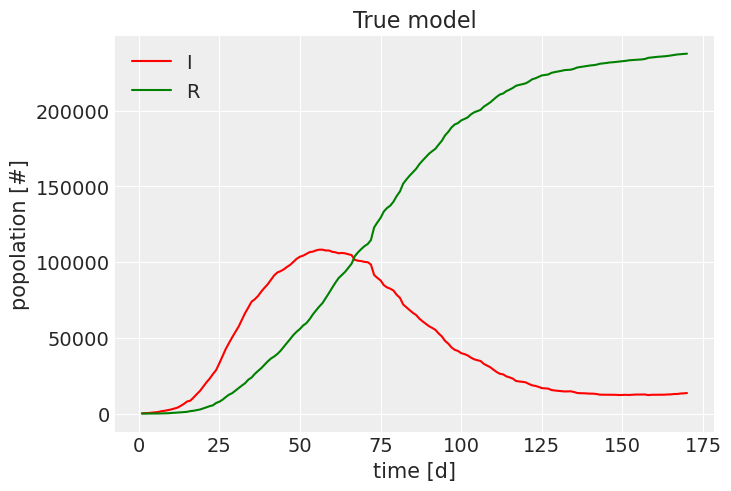

In [330]:
# Initialise a model

model_true = Dynamical_System('covid_dataset_IR.csv')

# Plot the true PDE solution and the signal (data)

model_true.plot_model('True model')

In [331]:
#!

class Dynamical_System_Forward(Dynamical_System):
  '''
  SEIR epidemiological model for given sigma, gamma
  '''

  def __init__(self, days, time_step, initN, initE, initI, initR, var_lik):

    # Initial conditions

    self.initN = initN
    self.initE = initE
    self.initI = initI
    self.initR = initR

    self.initial_conditions = [initE, initI, initR, initN]

    # Set time discretization grid

    self.time_grid = np.arange(0, days+time_step, time_step) #!

    # Set variance for likelihood

    self.var_lik = var_lik

  def solve(self, sigma_random, gamma_random):

    beta_random = R0*gamma_random
    self.sol = ode_solver(self.time_grid, self.initial_conditions, [beta_random, sigma_random, gamma_random])

    self.S_interpolated = interp1d(self.time_grid, self.sol[:,0], kind = "linear")
    self.E_interpolated = interp1d(self.time_grid, self.sol[:,1], kind = "linear")
    self.I_interpolated = interp1d(self.time_grid, self.sol[:,2], kind = "linear")
    self.R_interpolated = interp1d(self.time_grid, self.sol[:,3], kind = "linear")

  def plot_model(self, title):
      
    plt.figure()
    plt.plot(self.time_grid, self.sol[:,0], label = "S", color = "blue")
    plt.plot(self.time_grid, self.sol[:,1], label = "E", color = "orange" )
    plt.plot(self.time_grid, self.sol[:,2], label = "I", color = "red")
    plt.plot(self.time_grid, self.sol[:,3], label = "R", color = "green")

    plt.xlabel('time [d]')
    plt.ylabel('popolation [#]')
    plt.title(title)
    plt.legend(loc="best")

    plt.show()

  def sol_interpolated(self, times):
    return np.transpose(np.array([self.S_interpolated(times), self.E_interpolated(times), self.I_interpolated(times), self.R_interpolated(times)]))

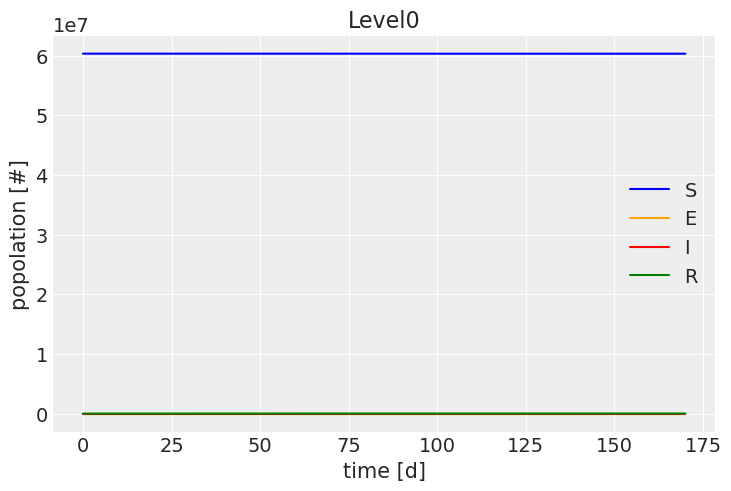

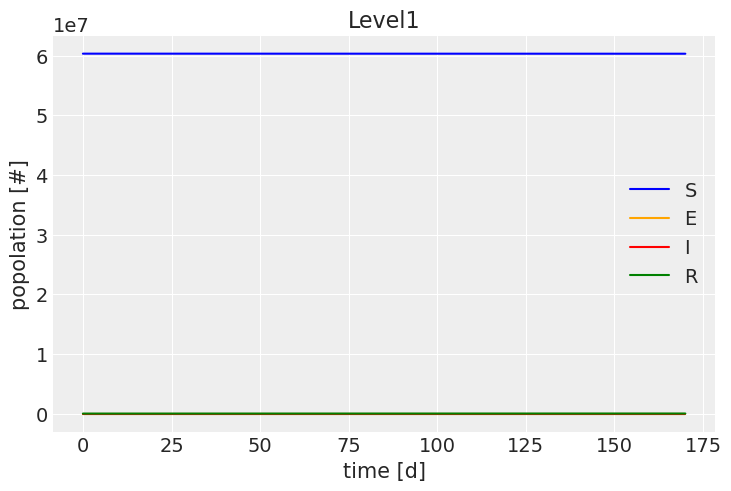

[0.002290964126586914, 0.0009958744049072266]


In [332]:
# Initialize the models, according to the mesh refinement degrees

my_models = []

for i in range(len(time_step_models)):
    my_models.append(Dynamical_System_Forward(days, time_step_models[i], initN, initE, initI, initR, var_lik[i]))

# Plot the solutions and compare meshes

my_models_time = []


for i,current_model in enumerate(my_models):

    begin = time.time()
    current_model.solve(sigma_true, gamma_true)
    my_models_time.append(time.time()-begin)

    current_model.plot_model('Level'+str(i))

plt.show()

print(my_models_time)

## Define a Theano Op for the likelihood

See https://docs.pymc.io/en/stable/pymc-examples/examples/case_studies/blackbox_external_likelihood.html for the complete explanation of the procedure

In [333]:
#!

# Define log likelihood

def my_loglik(my_model, sigma_random, gamma_random, model_true):
  
  my_model.solve(sigma_random, gamma_random) # compute system solution
  
  return -np.sum((my_model.I_interpolated(model_true.time_grid) - model_true.I) ** 2) \
            /(2 * (my_model.var_lik)**2) # compare the solution with the data 

In [334]:
# Define Theano operation class to compute custom log likelihood

class LogLike(tt.Op):

    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, my_model, loglike, model_true, pymc3_model): # add inputs as class attributes

        self.my_model    = my_model
        self.likelihood  = loglike
        self.model_true  = model_true
        self.pymc3_model = pymc3_model

    
    def perform(self, node, inputs, outputs):          # the method that is used when calling the Op
        
        # Store random parameters
        (params,) = inputs 

        # Calculate the likelihood value
        outputs[0][0] = np.array(self.likelihood(self.my_model, params[0], params[1], self.model_true))

        # Save the quantity of interest to the pymc3 model variable Q
        self.pymc3_model.Q.set_value(QoI(self.my_model))


# Create coarse and fine models in Pymc3

In [335]:
# Set up models in PyMC3 for each level

logl          = []
coarse_models = []
fine_model    = []


for j in range(len(my_models)):

    with pm.Model() as model:

        # Quantity of Interest Q

        Q = pm.Data("Q", np.ndarray(shape=(n_qoi,), buffer=np.zeros(n_qoi)))
        
        # Priors

        sigma_random = pm.Uniform(name = 'sigma_random', lower = lower_sigma, upper = upper_sigma)
        gamma_random = pm.Uniform(name = 'gamma_random', lower = lower_gamma, upper = upper_gamma)

        params = tt.as_tensor_variable([sigma_random, gamma_random])

        # Loglikelihood

        logl.append(LogLike(my_models[j], my_loglik, model_true, model))

        pm.Potential("likelihood", logl[j](params))

    if(j+1 < len(my_models)):
      coarse_models.append(model)
    else:
      fine_model.append(model)

# Perform Inference

In [336]:
method_names = []
traces       = []
runtimes     = []
colors       = []

with fine_model[0]:

    # Set the starting point for sampling

    if(use_MAP_as_start):
        starting_point = pm.find_MAP()

    else:
        starting_point = {'sigma_random': sigma_0, 'gamma_random': gamma_0}

    print('Starting point: ', starting_point)

    # Perform M

    if(perform_M):

        step_M = pm.Metropolis(tune          = tune, 
                               tune_interval = tune_interval)


        t_start = time.time()

        trace_M = pm.sample(draws                = ndraws_M,
                            step                 = step_M,
                            chains               = nchains_M,
                            tune                 = nburn_M,
                            discard_tuned_samples= discard_tuning,
                            random_seed          = RANDOM_SEED,
                            start                = starting_point,
                            cores                = 1)

        runtime_M = time.time() - t_start

        method_names.append('Metropolis')
        traces.append(trace_M)
        runtimes.append(runtime_M)
        colors.append('deepskyblue')

    
    # Perform DEMetropolisZ

    if(perform_DMZ):

        step_DMZ = pm.DEMetropolisZ(tune_interval=tune_interval)

        t_start = time.time()

        trace_DMZ = pm.sample(draws                = ndraws_DMZ,
                              step                 = step_DMZ,
                              chains               = nchains_DMZ,
                              tune                 = nburn_DMZ,
                              discard_tuned_samples= discard_tuning,
                              random_seed          = RANDOM_SEED,
                              start                = starting_point,
                              cores                = 1)

        runtime_DMZ = time.time() - t_start

        method_names.append('DEMetropolisZ')
        traces.append(trace_DMZ)
        runtimes.append(runtime_DMZ)
        colors.append('blue')



    # Perform MLDA

    if(perform_MLDA_without_variance_reduction):
        
        ## MLDA without variance reduction

        step_MLDA = pm.MLDA(coarse_models      = coarse_models,
                            subsampling_rates  = nsub_MLDA,
                            base_tune_interval = tune_interval,
                            variance_reduction = False,
                            store_Q_fine       = True)
        
        t_start = time.time()

        trace_MLDA_without_variance_reduction = pm.sample(draws                = ndraws_MLDA,
                                                          step                 = step_MLDA,
                                                          chains               = nchains_MLDA,
                                                          tune                 = nburn_MLDA,
                                                          discard_tuned_samples= discard_tuning,
                                                          random_seed          = RANDOM_SEED,
                                                          cores                = 1,
                                                          start                = starting_point)

        runtime_MLDA_without_VR = time.time() - t_start

        method_names.append('MLDA without VR')
        traces.append(trace_MLDA_without_variance_reduction)
        runtimes.append(runtime_MLDA_without_VR)
        colors.append('red')


    if(perform_MLDA_with_variance_reduction): 

        ## MLDA with variance reduction

        step_MLDA = pm.MLDA(coarse_models      = coarse_models,
                            subsampling_rates  = nsub_MLDA,
                            #base_tune_interval = tune_interval,
                            variance_reduction = True)

        t_start = time.time()

        trace_MLDA_with_variance_reduction = pm.sample(draws                = ndraws_MLDA,
                                                       step                 = step_MLDA,
                                                       chains               = nchains_MLDA,
                                                       tune                 = nburn_MLDA,
                                                       discard_tuned_samples= discard_tuning,
                                                       random_seed          = RANDOM_SEED,
                                                       cores                = 1,
                                                       start                = starting_point)

        runtime_MLDA_with_VR = time.time() - t_start

        method_names.append('MLDA with VR')
        traces.append(trace_MLDA_with_variance_reduction)
        runtimes.append(runtime_MLDA_with_VR)
        colors.append('darkorange')

Starting point:  {'sigma_random': 0.25, 'gamma_random': 0.5}


# Visualize summary quantities

In [337]:
# Summary quantities

ess          = []  # collect ESS
ess_n        = []  # collect ESS normlized wrt number of samples
acc          = []  # collect acceptance rates
performances = []  # collect ESS per second

with model:

    for i, trace in enumerate(traces):

        print(f"\n{method_names[i]} Sampler:\n")
        print('sigma:    ', sigma_true)
        print('gamma: ', gamma_true)
        display(pm.stats.summary(trace))

        ess.append  (np.array(pm.ess(trace).to_array()))
        ess_n.append(ess[i] / len(trace) / trace.nchains)
        acc.append  (trace.get_sampler_stats('accepted').mean())
        performances.append(ess[i] / runtimes[i])

        print(f"\n{method_names[i]} Sampler:\n"
              f'\nAcceptance rate:     {acc[i]}'
              f'\nRuntime:             {runtimes[i]} seconds'
              f'\nESS list:            {ess[i]}'
              f'\nNormalised ESS list: {ess_n[i]}'
              f'\nESS/sec:             {performances[i]}\n\n\n')

## Plot ESS and ESS per second quantities

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


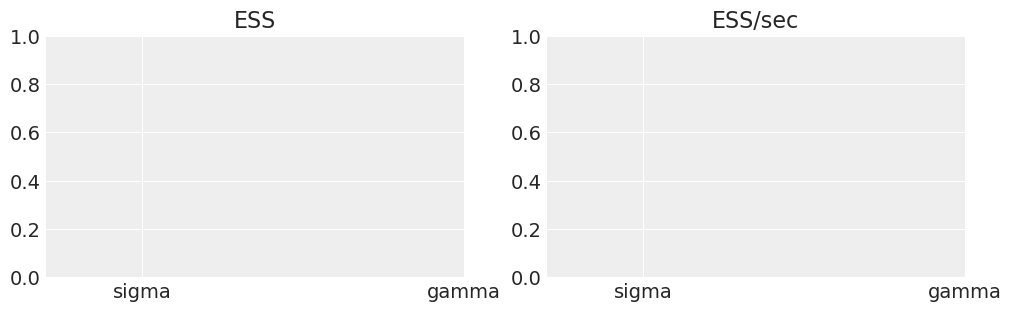

In [338]:
# Plot the effective sample size (ESS) and relative ESS (ES/sec) of each of the sampling strategies

with model:

    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    axes[0].set_title("ESS")
    for i, e in enumerate(ess):
        axes[0].bar(
                    [j + i * 0.2 for j in range(n_params)],
                    e.ravel(),
                    width=0.2,
                    color=colors[i],
                    label=method_names[i],
                    )
    axes[0].set_xticks([i + 0.3 for i in range(n_params)])
    axes[0].set_xticklabels(["sigma", "gamma"])
    axes[0].legend()

    axes[1].set_title("ESS/sec")
    for i, p in enumerate(performances):
        axes[1].bar(
                    [j + i * 0.2 for j in range(n_params)],
                    p.ravel(),
                    width=0.2,
                    color=colors[i],
                    label=method_names[i],
                    )
    axes[1].set_xticks([i + 0.3 for i in range(n_params)])
    axes[1].set_xticklabels(["sigma", "gamma"])
    axes[1].legend()
    plt.show()

# Plot traces and posteriors

In [339]:
# Plot traces and posteriors

with model:
    
    lines = [('sigma_random', {}, sigma_true), ('gamma_random', {}, gamma_true)]

    for i, trace in enumerate(traces):
        print(method_names[i])
        az.plot_trace(trace, lines=lines, figsize=(15,3))
        plt.show()
        print('\n\n\n')

# Plot autocorrelation

In [340]:
# Plot autocorrelation

for i, trace in enumerate(traces):
    print(method_names[i])
    az.plot_autocorr(trace, figsize=(20,5), combined=True)
    plt.show()
    print('\n\n\n')

# Plot Likelihood

/var/folders/zh/jv1b2t351dx2rqz29grjnb_r0000gn/T/ipykernel_22563/1713514366.py:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(sf)


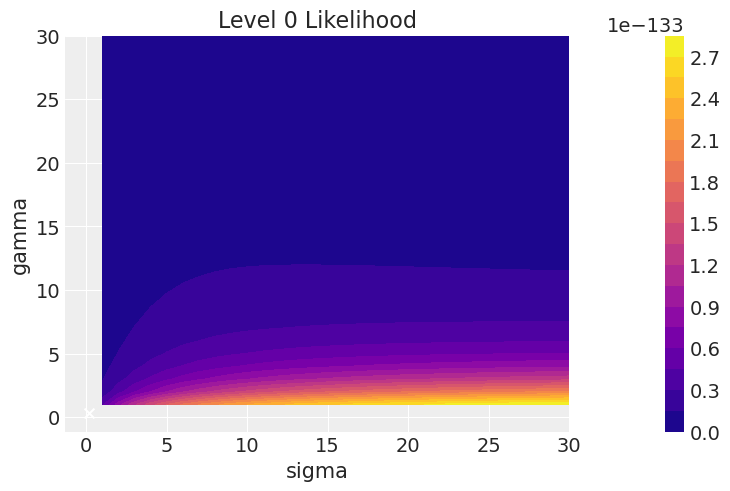

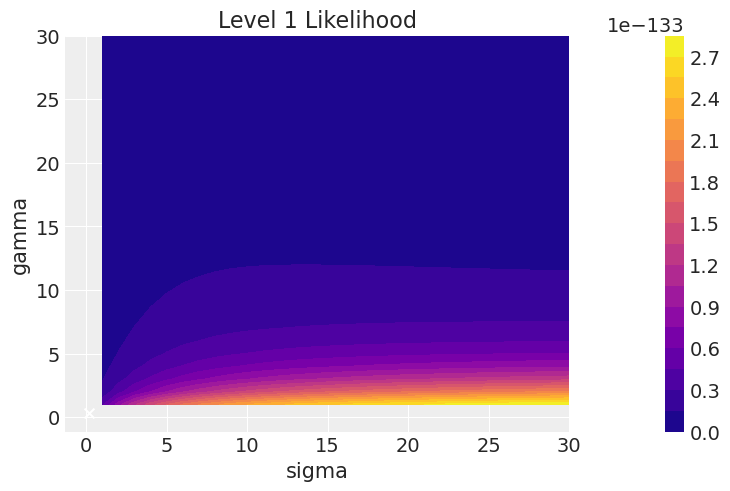

In [341]:
#!

# Likelihood as a function of the random parameters

if (plot_likelihood):

    sigma_range = np.linspace(lower_sigma, upper_sigma, n_ref_lik)
    gamma_range = np.linspace(lower_gamma, upper_gamma,   n_ref_lik)

    sigma_test, gamma_test = np.meshgrid(sigma_range,gamma_range)

    for l in range(len(var_lik)):

        loglik_test = np.ones(shape = sigma_test.shape)

        for i in range(len(sigma_test)):
            for j in range(len(sigma_test)):
                
                loglik_test[i][j] = my_loglik(my_models[l], sigma_test[i][j], gamma_test[i][j], model_true)

        #contours = plt.contour(sigma_test, gamma_test, np.exp(loglik_test), contour_lik, colors='black')
        #plt.clabel(contours, inline=True, fontsize=8, fmt="%1.6f")

        sf = plt.contourf(sigma_test, gamma_test, np.exp(loglik_test), contour_lik, cmap='plasma')   #RdGy
        plt.scatter(sigma_true,gamma_true, marker='x', s = 50, c='white')
        plt.colorbar(sf)
        plt.title('Level ' + str(l) + ' Likelihood')
        plt.xlabel("sigma")
        plt.ylabel("gamma")
        plt.savefig("likel" + str(l) + ".png")
        plt.show()

# Estimates Standard Errors of the methods

In [342]:
# Extract quantities of interest from the traces

## MLDA without VR
if(perform_MLDA_without_variance_reduction):
  Q_1 = trace_MLDA_without_variance_reduction.get_sampler_stats("Q_1").reshape((nchains_MLDA * ndraws_MLDA,)) # Q_i where i=levels-1
  Q_1 = np.array(list(Q_1))


## MLDA with VR
if(perform_MLDA_with_variance_reduction):

  ### PAY ATTENTION ON HOW MANY TIMES YOU HAVE TO MULTIPLY BY NSUB: IT DEPENDS ON THE LEVELS
  Q_0   = np.concatenate(trace_MLDA_with_variance_reduction.get_sampler_stats("Q_0"  )).reshape((nchains_MLDA * ndraws_MLDA * nsub_MLDA, n_qoi)) 
  Q_1_0 = np.concatenate(trace_MLDA_with_variance_reduction.get_sampler_stats("Q_1_0")).reshape((nchains_MLDA * ndraws_MLDA,             n_qoi))


# Estimates

if(perform_MLDA_without_variance_reduction):
  Q_mean_standard = Q_1.mean(axis = 0)
  print(f"Q_1 mean   = {Q_1.mean(axis = 0)}\n")


if(perform_MLDA_with_variance_reduction):
  Q_mean_vr = Q_0.mean(axis=0) + Q_1_0.mean(axis=0)
  print(f"Q_0 mean   = {Q_0.mean(axis=0)}")
  print(f"Q_1_0 mean = {Q_1_0.mean(axis=0)}\n")


if(perform_MLDA_without_variance_reduction):
  print(f"Standard method:    Mean: {Q_mean_standard}\n")


if(perform_MLDA_with_variance_reduction):
  print(f"VR method:          Mean: {Q_mean_vr}\n")


# Calculate variances of Q quantity samples

if(perform_MLDA_without_variance_reduction):
  Q_1_var = Q_1.var(axis=0)
  print(f"Q_1 var   = {Q_1_var}\n")


if(perform_MLDA_with_variance_reduction):
  Q_0_var   = Q_0.var(axis=0)
  Q_1_0_var = Q_1_0.var(axis=0)
  print(f"Q_0 var   = {Q_0_var}")
  print(f"Q_1_0_var = {Q_1_0_var}\n")

In [343]:
## Calculate standard error of each term using ESS

if(perform_MLDA_without_variance_reduction):

  ess_Q1 = np.zeros(n_qoi)
  for i in range(n_qoi):
    ess_Q1[i] = az.ess(np.array(Q_1[:,i], np.float64))

  print("Without VR ESS:  ", ess_Q1)

  # Standard Error Estimate
  print("Without VR Standard Error: ", Q_1_var/ess_Q1)

if(perform_MLDA_with_variance_reduction):

  # note that the chain in level 1 has much fewer samples than the chain in level 0 (because of the subsampling rates)
  ess_Q0    = np.zeros(n_qoi)
  ess_Q_1_0 = np.zeros(n_qoi)
  for i in range(n_qoi):
    ess_Q0[i]    = az.ess(np.array(Q_0  [:,i], np.float64))
    ess_Q_1_0[i] = az.ess(np.array(Q_1_0[:,i], np.float64))

  print("With VR ESS:     ", ess_Q0, ess_Q_1_0)

  # Standard Error Estimates
  print("With VR Standard Errors:   ", Q_0_var/ess_Q0,'   ', Q_1_0_var/ess_Q_1_0)

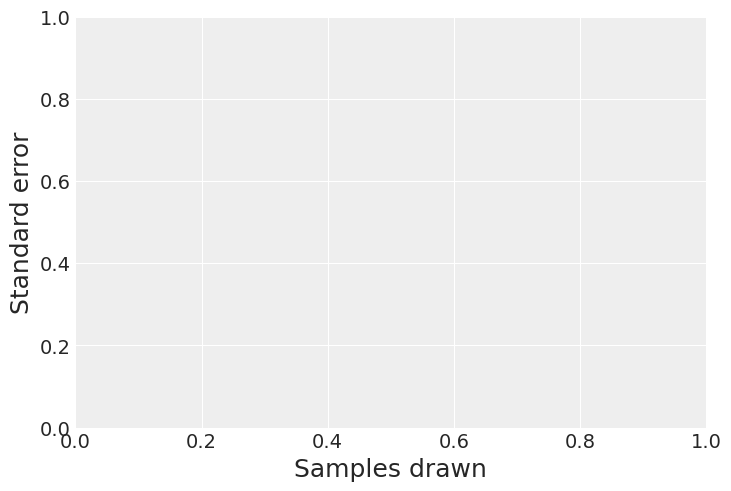

In [344]:
## Calculate total standard errors of the two competing estimates with different chunks of the sample

from matplotlib.ticker import ScalarFormatter

step = 2  # 100

if(perform_MLDA_without_variance_reduction):
  Q1_SE         = np.zeros((int(nchains_MLDA * ndraws_MLDA / step), n_qoi))
  E_standard_SE = np.zeros((int(nchains_MLDA * ndraws_MLDA / step), n_qoi))


if(perform_MLDA_with_variance_reduction):
  Q0_SE    = np.zeros((int(nchains_MLDA * ndraws_MLDA / step), n_qoi))
  Q_1_0_SE = np.zeros((int(nchains_MLDA * ndraws_MLDA / step), n_qoi))
  E_VR_SE  = np.zeros((int(nchains_MLDA * ndraws_MLDA / step), n_qoi))

k = 0

for i in np.arange(step, nchains_MLDA * ndraws_MLDA + 1, step):

  for q in range(n_qoi):      

    try:
      Q1_SE[k,q] = Q_1[0:i, q].var(axis=0) / az.ess(np.array(Q_1[0:i,q], np.float64))
      E_standard_SE[k,q] = np.sqrt(Q1_SE[k,q])
    except:
      pass

    try:
      Q0_SE   [k,q] = Q_0  [0 : i * nsub_MLDA, q].var(axis=0) / az.ess(np.array(Q_0  [0 : i * nsub_MLDA,q], np.float64))
      Q_1_0_SE[k,q] = Q_1_0[0 : i,             q].var(axis=0) / az.ess(np.array(Q_1_0[0 : i,            q], np.float64))
      E_VR_SE [k,q] = np.sqrt(Q0_SE[k,q] + Q_1_0_SE[k,q])
    except:
      pass

  k += 1

fig = plt.figure()
ax  = fig.gca()
legend_strings = []

for axis in [ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

if(perform_MLDA_without_variance_reduction):
  ax.plot(np.arange(step, nchains_MLDA * ndraws_MLDA + 1, step), E_standard_SE)
  legend_strings.append(f"Standard estimator {qoi_names[0]}")
  legend_strings.append(f"Standard estimator {qoi_names[1]}")


if(perform_MLDA_with_variance_reduction):
  ax.plot(np.arange(step, nchains_MLDA * ndraws_MLDA + 1, step), E_VR_SE)
  legend_strings.append(f"Variance Reduction {qoi_names[0]}")
  legend_strings.append(f"Variance Reduction {qoi_names[1]}")

ax.legend(legend_strings, fontsize = "small")

plt.xlabel("Samples drawn",  fontsize=18)
plt.ylabel("Standard error", fontsize=18)

plt.savefig('mu_sigma_std_err.png')
plt.show()